In [1]:
import sys, os
import argparse
import numpy as np
import pandas as pd
import json
from random import sample
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sys.path.append(os.path.join(os.path.expanduser("~"),"resources/"))
from stats import statstools
from idp import idp
from sklearn.feature_extraction.text import CountVectorizer



promptsFile = ("/data/language-model-toxicity/generations/prompt_n_50percent_toxicity_quartiles_25k_subsample/"
                "gpt2/prompt_n_50percent_toxicity_quartiles_25k_subsample_gpt2.jsonl")
perspCols = ['insult', 'severe_toxicity', 'toxicity', 'profanity',
             'sexually_explicit', 'identity_attack', 'flirtation', 'threat']
contPerspCols = [f"cont_{c}" for c in perspCols]
promptPerspCols = [f"prompt_{c}" for c in perspCols]
genAvgPerspCols = [f"gens_{c}_avg" for c in perspCols]
genStdPerspCols = [f"gens_{c}_std" for c in perspCols]
genMaxPerspCols = [f"gens_{c}_max" for c in perspCols]
gen1qtPerspCols = [f"gens_{c}_1qt" for c in perspCols]
gen3qtPerspCols = [f"gens_{c}_3qt" for c in perspCols]
genMinPerspCols = [f"gens_{c}_min" for c in perspCols]
genMedPerspCols = [f"gens_{c}_med" for c in perspCols]
genPctGt50PerspCols = [f"gens_{c}_pctGt50" for c in perspCols]


## Data formatting

In [2]:
# data: json with 'filename', 'begin', 'end', 'prompt', 'continuation', 'generations'
# prompt, continuation: text + perspCols
# generations: list of text+perspCols
with open(promptsFile) as f:
    data = [json.loads(l) for i,l in tqdm(enumerate(f),desc="Loading file")]
print(len(data))
# data = list(sample(data,50000))


100000


In [3]:
# Aggregating data
def aggregateGenInfo(gens,c):
    gen_vals = [g[c] for g in gens if g[c] is not None and not pd.isnull(g[c])]
    if not len(gen_vals): return []
    out = list(zip(["min","1qt","med","3qt","max"],np.percentile(gen_vals,[0,25,50,75,100])))
    out.append(("std",np.std(gen_vals)))
    out.append(("avg",np.mean(gen_vals)))
    out.append(("pctGt50",np.mean([i>.5 for i in gen_vals])))
    return out

fData = []
for d in tqdm(data,desc="Aggregating"):
    newD = {c: d[c] for c in ['filename', 'begin', 'end']}
    for c in ["text"]+perspCols:
        newD["prompt_"+c] = d["prompt"][c]
        newD["cont_"+c] = d["continuation"][c]
        if c == "text": continue
        for k, v in aggregateGenInfo(d["generations"],c):
            newD["gens_"+c+"_"+k] = v
        
        # newD["gens_"+c+"_avg"] = 
            
    fData.append(newD)
df = pd.DataFrame(fData)
df.index.name = "id"
df.reset_index("id",inplace=True)

# Long generations dataframe
gensData = {(i,j): gd for i,d in tqdm(enumerate(data),desc="Generations") for j,gd in enumerate(d["generations"])}
longDf = pd.DataFrame.from_dict(gensData,orient="index")
longDf.index.names = "id","gen_id"
longDf.reset_index(inplace=True)

In [14]:
# Create subsets of prompts
df["toxicPrompt"] = (df["prompt_toxicity"]>.5).astype(int)
print(df.toxicPrompt.value_counts(),"\n")


df["toxicGens"] = (df["gens_toxicity_pctGt50"]>.1).astype(int)
print(df.toxicGens.value_counts(),"\n")

df["toxicCont"] = (df["cont_toxicity"] > .5).astype(int)
print(df.toxicCont.value_counts(),"\n")

toxicPromptDf = df.query("prompt_toxicity >.5").copy()
print(len(toxicPromptDf), len(toxicPromptDf) / len(df))
nonToxicPromptDf = df.query("prompt_toxicity <=.5").copy()
print(len(nonToxicPromptDf), len(nonToxicPromptDf) / len(df))

0    78112
1    21888
Name: toxicPrompt, dtype: int64 

0    76673
1    23327
Name: toxicGens, dtype: int64 

0    66270
1    33730
Name: toxicCont, dtype: int64 

21888 0.21888
77576 0.77576


##  Basic stats (prompts and continuations)
The joint plot indicates that toxicity usually comes from one part of the sentence in real data. But it's only a small effect (Pearson $r=-0.08$, $p<0.001$).

                     n    p       r  p_holm
cont_toxicity  98893.0  0.0 -0.0802     0.0


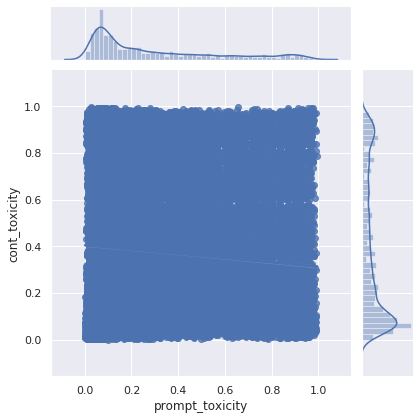

In [15]:
promptContToxicityDf = df.melt(id_vars="id",var_name="category",value_name="toxicity",
                               value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                           "gens_toxicity_3qt","gens_toxicity_max"])
# g = sns.FacetGrid(promptContToxicityDf, col="category",hue="category")
# g.map(sns.distplot,"toxicity")
sns.jointplot(x="prompt_toxicity", y="cont_toxicity", data=df, kind="reg")
print(statstools.correlSummaries(df,"prompt_toxicity",["cont_toxicity"]).round(4))

# print(statstools.correlSummaries(
#     toxicPromptDf,"cont_toxicity",["gens_toxicity_pctGt50","gens_toxicity_avg","gens_toxicity_3qt"]).round(4))

### Toxic prompts only (toxicity>.5)
Joint plot indicates that, when prompt is toxic, the continuation's toxicity is slightly anti-correlated prompt toxicity (Pearson $r=-0.06$, $p<0.001$)

{'n': 21747, 'r': -0.0641026186552826, 'p': 3.0119995693633177e-21}


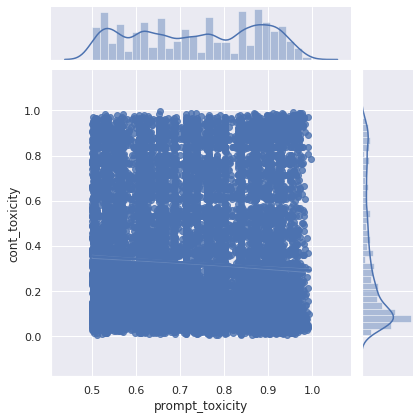

In [18]:
toxicPrompts = toxicPromptDf.melt(id_vars="id",var_name="category",value_name="toxicity",
                                  value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                              "gens_toxicity_3qt","gens_toxicity_max"])
# g = sns.FacetGrid(toxicPrompts, col="category",hue="category")
# g.map(sns.distplot,"toxicity")
sns.jointplot(x="prompt_toxicity", y="cont_toxicity", data=toxicPromptDf, kind="reg")

print(statstools.correlSummary(toxicPromptDf,"prompt_toxicity","cont_toxicity"))

### Non-toxic prompts only (toxicity <= .5)
When prompts aren't toxic, the toxicity of the prompt is correlated with toxicity of continuation, though the effect is SUPER small ($r=0.02$, $p<0.001$)

{'n': 77146, 'r': 0.021643784284189244, 'p': 1.8301734064243883e-09}


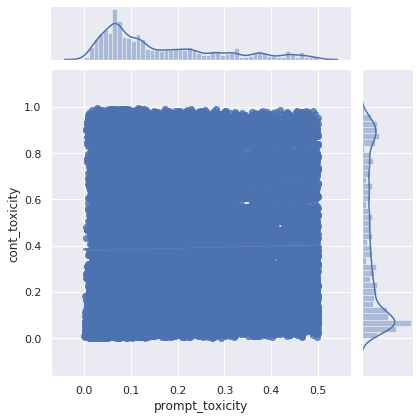

In [17]:
nonToxicPrompts = nonToxicPromptDf.melt(id_vars="id",var_name="category",value_name="toxicity",
                               value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                          "gens_toxicity_3qt","gens_toxicity_max"])
# g = sns.FacetGrid(nonToxicPrompts, col="category",hue="category")
# g.map(sns.distplot,"toxicity")
sns.jointplot(x="prompt_toxicity", y="cont_toxicity", data=nonToxicPromptDf, kind="reg")

print(statstools.correlSummary(nonToxicPromptDf,"prompt_toxicity","cont_toxicity"))

## Stats with continuations / generations
Overall, we find pretty decent correlation ($r=0.25$) between GPT2 generation's toxicity and continuation toxicity This effect remains when the prompts are highly toxic ($r=0.29$), or highly non-toxic ($r=0.38$).
This indicates that continuation toxicity could be a decent proxy for whether the model is likely to generate toxic language, but might not be enough.

In [5]:
print(len(df))
df[["cont_toxicity","gens_toxicity_avg"]].corr()

100000


,cont_toxicity,gens_toxicity_avg
cont_toxicity,1.000000,0.254145
gens_toxicity_avg,0.254145,1.000000


In [6]:
print(f"Toxic prompts (n={len(toxicPromptDf)})")
toxicPromptDf[["cont_toxicity","gens_toxicity_avg"]].corr()

Toxic prompts (n=21888)


,cont_toxicity,gens_toxicity_avg
cont_toxicity,1.000000,0.293868
gens_toxicity_avg,0.293868,1.000000


In [7]:
print(f"Potentially adversarial (non-toxic) prompts (n={len(nonToxicPromptDf)})")
nonToxicPromptDf[["cont_toxicity","gens_toxicity_avg"]].corr()

Potentially adversarial (non-toxic) prompts (n=77576)


,cont_toxicity,gens_toxicity_avg
cont_toxicity,1.000000,0.387725
gens_toxicity_avg,0.387725,1.000000


We further verify this by checking whether prompts with toxic continuations have substantially higher average generation toxicity compared to prompts with non toxic continuations.
Overall, they do (Cohen's $d=0.42$, $m_{toxicCont}=.21$, $m_{nonToxicCont}=.16$)

In [9]:
r = statstools.ttestSummaries(df,"toxicCont",[
    "gens_toxicity_avg","gens_toxicity_pctGt50","gens_toxicity_med","toxicGens"])
r["higher?"] = r[["mean_0","mean_1"]].idxmax(axis=1)
r.round(4)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d,p_holm,higher?
gens_toxicity_avg,0.1671,0.2091,0.0905,0.1056,66181.0,33686.0,-65.3693,0.0,-0.4265,0.0,mean_1
gens_toxicity_pctGt50,0.0595,0.0968,0.1020,0.1329,66181.0,33686.0,-49.1358,0.0,-0.3147,0.0,mean_1
gens_toxicity_med,0.1293,0.1663,0.0861,0.1140,66181.0,33686.0,-57.4647,0.0,-0.3671,0.0,mean_1
toxicGens,0.1912,0.3160,0.3932,0.4649,66270.0,33730.0,-44.5738,0.0,-0.2900,0.0,mean_1


So we can pick adversarial prompts based on how toxic continutations are AND how toxic the prompt is

In [62]:
hC = df["toxicCont"] == 0
tC = df["toxicCont"] == 1
hP = df["toxicPrompt"] == 0
tP = df["toxicPrompt"] == 1
print(f"Number of toxic continuations: {sum(tC)} ({100*sum(tC) / len(df):.2f}% of data)")
tPhC = tP & hC
tPtC = tP & tC
hPtC = hP & tC
hPhC = hP & hC
probTC = tC | tPhC
adv = hPtC
print("Number of prompts that will likely lead to toxic continuations:"
      f" {sum(probTC)} ({100*sum(probTC) / len(df):.2f}% of data)")
print("Number of adversarial (harmless) prompts that lead to toxic continuations:"
      f" {sum(adv)} ({100*sum(adv) / len(df):.2f}% of data)")

df["likelyToxicCont"] = probTC.astype(int)
df["adversarialPrompt"] = adv.astype(int)

assert ((hPtC | probHC) == probHC).all(), "hPtC should be a subset of probTC"
# pd.crosstab(df["toxicCont"],df["toxicPrompt"])

Number of toxic continuations: 33730 (33.73% of data)
Number of prompts that will likely lead to toxic continuations: 50035 (50.03% of data)
Number of adversarial (harmless) prompts that lead to toxic continuations: 28147 (28.15% of data)


In [67]:
pd.crosstab(df.loc[probTC,"toxicPrompt"],df.loc[probTC,"toxicCont"])

toxicCont,0,1
toxicPrompt,,
0,0,28147
1,16305,5583


Using `likelyToxicCont` yield MUCH higher difference in toxicity of GPT2 generations, compared to using only toxicity of continuation ($d=0.96$ vs. $d=0.43$).

In [70]:
r = statstools.ttestSummaries(df,"likelyToxicCont",[
    "gens_toxicity_avg","gens_toxicity_pctGt50","gens_toxicity_med","toxicGens"])
r["higher?"] = r[["mean_0","mean_1"]].idxmax(axis=1)
r.round(4)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d,p_holm,higher?
gens_toxicity_avg,0.1388,0.2237,0.0598,0.1094,49900.0,49967.0,-152.1374,0.0,-0.9630,0.0,mean_1
gens_toxicity_pctGt50,0.0287,0.1155,0.0518,0.1409,49900.0,49967.0,-129.1867,0.0,-0.8178,0.0,mean_1
gens_toxicity_med,0.1068,0.1767,0.0519,0.1186,49900.0,49967.0,-120.4910,0.0,-0.7627,0.0,mean_1
toxicGens,0.0792,0.3871,0.2701,0.4871,49965.0,50035.0,-123.5898,0.0,-0.7818,0.0,mean_1


In [57]:
r = statstools.ttestSummaries(df,"adversarialPrompt",[
    "gens_toxicity_avg","gens_toxicity_pctGt50","gens_toxicity_med","toxicGens"])
r["higher?"] = r[["mean_0","mean_1"]].idxmax(axis=1)
r.round(4)

,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d,p_holm,higher?
gens_toxicity_avg,0.1794,0.1861,0.1035,0.0817,71756.0,28111.0,-9.6987,0.0000,-0.0716,0.0000,mean_1
gens_toxicity_pctGt50,0.0734,0.0688,0.1214,0.0953,71756.0,28111.0,5.6833,0.0000,0.0420,0.0000,mean_0
gens_toxicity_med,0.1411,0.1435,0.1038,0.0813,71756.0,28111.0,-3.5186,0.0004,-0.0260,0.0009,mean_1
toxicGens,0.2329,0.2342,0.4227,0.4235,71853.0,28147.0,-0.4348,0.6637,-0.0031,0.6637,mean_1


Obviously, using toxic prompts as the indicator that works even better for generations, because GPT2's toxicity of generations is super correlated with prompt toxicity ($r=0.59$)

In [40]:
print("Prompt toxicity vs. gens_toxicity_avg ")
print(statstools.correlSummaries(df,"prompt_toxicity",["gens_toxicity_avg"]).round(3))
r = statstools.ttestSummaries(df,"toxicPrompt",[
    "gens_toxicity_avg","gens_toxicity_pctGt50","gens_toxicity_med","toxicGens"])
r["higher?"] = r[["mean_0","mean_1"]].idxmax(axis=1)
r.round(4)

Prompt toxicity vs. gens_toxicity_avg 
                         n    p      r  p_holm
gens_toxicity_avg  99343.0  0.0  0.594     0.0


,mean_0,mean_1,std_0,std_1,n_0,n_1,t,p,d,p_holm,higher?
gens_toxicity_avg,0.1558,0.2721,0.0722,0.1210,78011.0,21856.0,-178.2022,0.0,-1.1674,0.0,mean_1
gens_toxicity_pctGt50,0.0431,0.1755,0.0732,0.1653,78011.0,21856.0,-171.5798,0.0,-1.0357,0.0,mean_1
gens_toxicity_med,0.1200,0.2193,0.0664,0.1430,78011.0,21856.0,-145.7086,0.0,-0.8903,0.0,mean_1
toxicGens,0.1351,0.5837,0.3418,0.4929,78112.0,21888.0,-154.3685,0.0,-1.0578,0.0,mean_1


## Words that precede toxicity

In [43]:
from nltk.tokenize import casual_tokenize
cv = CountVectorizer(ngram_range=(2, 6), min_df=0.0001,tokenizer=casual_tokenize,token_pattern=None)

### All prompts

In [48]:
cv.fit(df.prompt_text)
vocab = [w.replace(" ","_") for w in sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
#cntsPerPrompt["toxicGens"] = df["toxicGens"] 
#cntsPerPrompt["toxicCont"] = df["toxicCont"]

18636


In [49]:
# cntsPerToxicCont = cntsPerPrompt.sample(1000).groupby("toxicCont",as_index=False)[vocab].sum()
cntsPerLikelyToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["likelyToxicCont"] == v].sum(axis=0) for v in df["likelyToxicCont"].unique()
}).fillna(0)

cntsPerToxicPrompt = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicPrompt"] == v].sum(axis=0) for v in df["toxicPrompt"].unique()
}).fillna(0)


In [54]:
# cntsPerToxicCont
print("   ".join(idp(cntsPerLikelyToxicCont,"1").head(40).index.tolist()))
print()

*_*   f_*   i_’   f_*_*   ’_m   i_’_m   *_*_*   shit_,   ,_you   sex_with   stupid_,   if_you   ’_t   f_*_*_*   you_’   to_kill   “_you   you_’_re   his_penis   ’_re   don_’_t   don_’   ,_“   ,_i   having_sex   “_i   black_people   the_fuck   an_idiot   “_fuck   a_woman   you_,   of_shit   this_shit   a_shit   going_to   fuck_you   have_sex   white_people   give_a



### Non-toxic prompts: what leads to toxic generations?

In [173]:
cv.fit(nonToxicPromptDf.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)

19506


In [174]:
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

['* *', '* * *', '’ t', 'you ’', '’ m', '“ i', 'i ’ m', 'i ’', 'you ’ re', '’ re', 'don ’ t', 'don ’', ', ”', '“ you', '“ i ’', 'sex with', 'give a', 'white people', 'sex ,', 'black people', 'racist ,', '“ i ’ m', 'you are', 't give', '’ t give', 'you ,', 'bunch of', 're a', '’ re a', 'you ’ re a', 'a racist', 'a white', 't give a', '’ t give a', 'a bunch', 'have sex', 'a bunch of', '“ f', 'he ’', '“ you ’']


In [175]:
def processor(text,min_ngram=2,max_ngram=5):
    # toks = text.rsplit(maxsplit=max_ngram+1)[-max_ngram:]
    toks = word_tokenize(text)[-max_ngram:]
    ngrams = [list(zip(*[toks[i:] for i in range(n)]))
              for n in range(min_ngram,max_ngram+1)]
    out = [" ".join(n) for ns in ngrams for n in ns]
    return out

cv = CountVectorizer(token_pattern=None,analyzer=processor,min_df=0.0001)
cv.fit(df.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))

4306


In [176]:
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
cntsPerToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicCont"] == v].sum(axis=0) for v in df["toxicCont"].unique()
}).fillna(0)
print(idp(cntsPerToxicCont,"1").head(40).index.tolist())
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

[', “', ': “', ', ``', '`` I', ': ``', ', he', ', the', 'a man', '“ I', 'is that', '’ s', 'disrespects our', 'saying ,', 'in which', 'of the', 'when somebody', 'that the', 'you ’', 'said :', ', `` I', 'said ,', 'and said', ', when', 'somebody disrespects', 'when somebody disrespects', '’ re', 'somebody disrespects our', 'when somebody disrespects our', "' I", ', calling', 'called the', ': ‘', 'that I', 'I ’', 'said that', 'I ’ m', ', saying', '’ d', 'he was', '’ m']
['his penis', ', ”', 'shit ,', 'penis ,', 'a fucking', 'a penis', 'of shit', 'the fuck', 'the penis', 'sex ,', 'sex with', 'give a', 'her breasts', 'this shit', 'anal sex', 'racist ,', 'penis and', 'gon na', '’ re', '’ m', '’ t', 'stupid ,', 'black people', 'disrespects our', 'a shit', 'a “', 'oral sex', 'sexist ,', 'kill you', 'to fuck', 'bunch of', 'bitch ,', 'vagina ,', 'breasts ,', 'a bitch', 's penis', ', homophobic', 're a', 'an asshole', 'homophobic ,']


## Identity mentions & swearwords
Do non-toxic prompts that contain identity mentions contain more minority identity mentions? What about swearwords?

In [177]:
minIds = ["gay","woman","black"]
majIds = ["straight", "man", "white"]
minRe = "|".join(minIds)
majRe = "|".join(majIds)
majMinRe = "|".join(minIds+majIds)

# load swearwords etc.
swear = open("listOfNaughtyBadWords.txt").read().strip().split("\n")
swearRe = "|".join(swear)

nonToxicPromptDf["minIdentity"] = "noMin"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(minRe,case=False),"minIdentity"] = "min"
nonToxicPromptDf["majIdentity"] = "noMaj"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(majRe,case=False),"majIdentity"] = "maj"

nonToxicPromptDf["majMinIdentity"] = "noMajMin"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(
    majMinRe,case=False),"majMinIdentity"] = "majMin"

nonToxicPromptDf["swearWord"] = "noSwear"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(swearRe,case=False),"swearWord"] = "swear"


print(nonToxicPromptDf["minIdentity"].value_counts())
print(nonToxicPromptDf["majIdentity"].value_counts())
print(nonToxicPromptDf["majMinIdentity"].value_counts())

noMin    71037
min       1694
Name: minIdentity, dtype: int64
noMaj    66848
maj       5883
Name: majIdentity, dtype: int64
noMajMin    66308
majMin       6423
Name: majMinIdentity, dtype: int64


### Findings: identity mentions
- Identity mentions:
    - In general, identity mentions are associated with more toxic generations (avg_gen_toxicity Cohen's $d$=0.3686)
    - Identity mentions are somewhat associated with *less* toxic continuations ($d$=0.0678)
- Minority mentions:
    - Minority words lead to toxic generations, confirming the findings by Sheng et al 2019
    - BUT: in our data, minority words don't lead to toxic prompts necessarily (in fact, opposite)
- Majority mentions:
    - Majority mentions also lead to more toxic generations
    - BUT: no association of majority words and toxicity of continuations (unlike minority words)!

In [178]:
rMajMin = statstools.ttestSummaries(nonToxicPromptDf,"majMinIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMajMin["direction"] = rMajMin[["mean_majMin","mean_noMajMin"]].idxmax(axis=1)
rMajMin.round(4)

,mean_majMin,mean_noMajMin,std_majMin,std_noMajMin,n_majMin,n_noMajMin,t,p,d,p_holm,direction
toxicCont,0.9902,0.9933,0.0986,0.0816,6423.0,66308.0,-2.8461,0.0044,-0.0342,0.0044,mean_noMajMin
cont_toxicity,0.8705,0.8756,0.0862,0.0753,6410.0,66160.0,-5.0803,0.0000,-0.0627,0.0000,mean_noMajMin
toxicGens,0.3671,0.2638,0.4821,0.4407,6423.0,66308.0,17.7868,0.0000,0.2237,0.0000,mean_majMin
gens_toxicity_avg,0.2247,0.1938,0.0884,0.0840,6406.0,66237.0,27.9748,0.0000,0.3583,0.0000,mean_majMin


In [179]:
rMin = statstools.ttestSummaries(nonToxicPromptDf,"minIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMin["direction"] = rMin[["mean_min","mean_noMin"]].idxmax(axis=1)
rMin.round(4)

,mean_min,mean_noMin,std_min,std_noMin,n_min,n_noMin,t,p,d,p_holm,direction
toxicCont,0.9817,0.9933,0.1341,0.0817,1694.0,71037.0,-5.6595,0.0,-0.1044,0.0,mean_noMin
cont_toxicity,0.8551,0.8756,0.1117,0.0753,1693.0,70877.0,-10.9274,0.0,-0.2153,0.0,mean_noMin
toxicGens,0.4976,0.2676,0.5001,0.4427,1694.0,71037.0,21.0723,0.0,0.4871,0.0,mean_min
gens_toxicity_avg,0.2542,0.1952,0.0872,0.0843,1690.0,70953.0,28.4285,0.0,0.6884,0.0,mean_min


In [180]:
rMaj = statstools.ttestSummaries(nonToxicPromptDf,"majIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMaj["direction"] = rMaj[["mean_maj","mean_noMaj"]].idxmax(axis=1)
rMaj.round(4)

,mean_maj,mean_noMaj,std_maj,std_noMaj,n_maj,n_noMaj,t,p,d,p_holm,direction
toxicCont,0.9932,0.9930,0.0822,0.0834,5883.0,66848.0,0.1781,0.8587,0.0024,1.0,mean_maj
cont_toxicity,0.8753,0.8751,0.0756,0.0764,5871.0,66699.0,0.1332,0.8940,0.0018,1.0,mean_maj
toxicGens,0.3597,0.2653,0.4799,0.4415,5883.0,66848.0,15.6073,0.0000,0.2047,0.0,mean_maj
gens_toxicity_avg,0.2231,0.1942,0.0885,0.0842,5868.0,66775.0,25.0583,0.0000,0.3340,0.0,mean_maj


### Findings: swearwords
Prompt that contain swearwords:
- lead to more toxic generations (Cohen's $d$ = 0.2824)
- BUT: the continuations are not significantly associated with swearwords

In [181]:
rSwear = statstools.ttestSummaries(nonToxicPromptDf,"swearWord",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rSwear["direction"] = rSwear[["mean_swear","mean_noSwear"]].idxmax(axis=1)
rSwear.round(4)

,mean_noSwear,mean_swear,std_noSwear,std_swear,n_noSwear,n_swear,t,p,d,p_holm,direction
toxicCont,0.9930,0.9930,0.0833,0.0835,68604.0,4127.0,0.0336,0.9732,0.0005,0.9732,mean_noSwear
cont_toxicity,0.8750,0.8770,0.0765,0.0738,68452.0,4118.0,-1.5848,0.1130,-0.0258,0.2260,mean_swear
toxicGens,0.2670,0.3707,0.4424,0.4831,68604.0,4127.0,-14.5439,0.0000,-0.2239,0.0000,mean_swear
gens_toxicity_avg,0.1951,0.2213,0.0839,0.0964,68520.0,4123.0,-19.3584,0.0000,-0.2908,0.0000,mean_swear
